In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## kmeans ontogeny

In [7]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


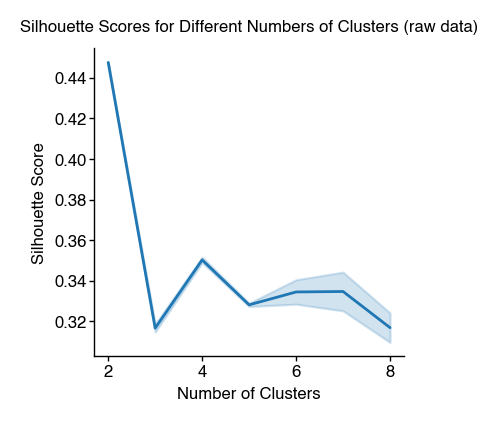

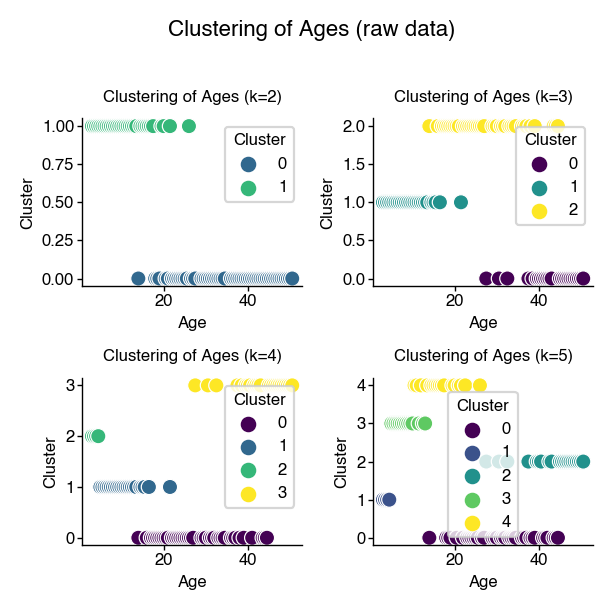

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


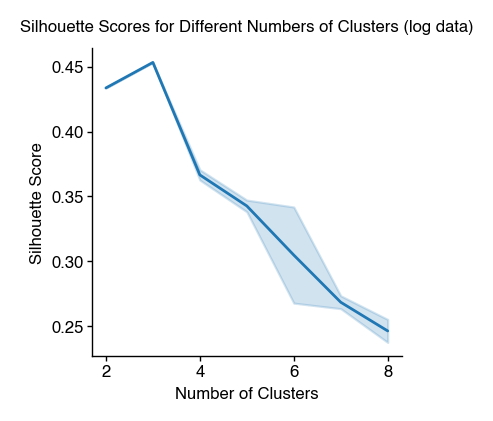

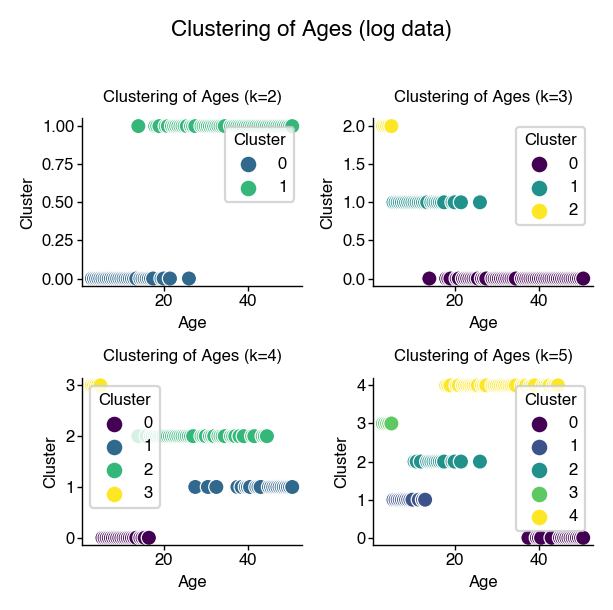

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


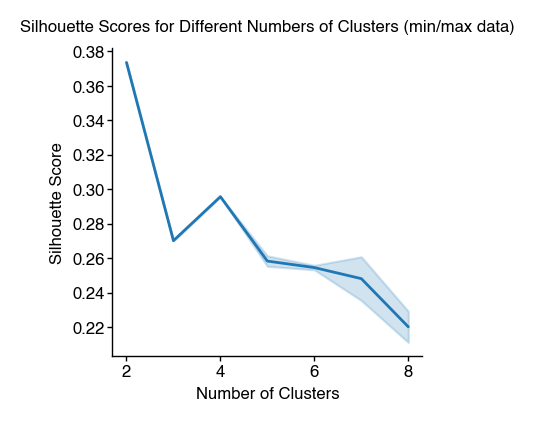

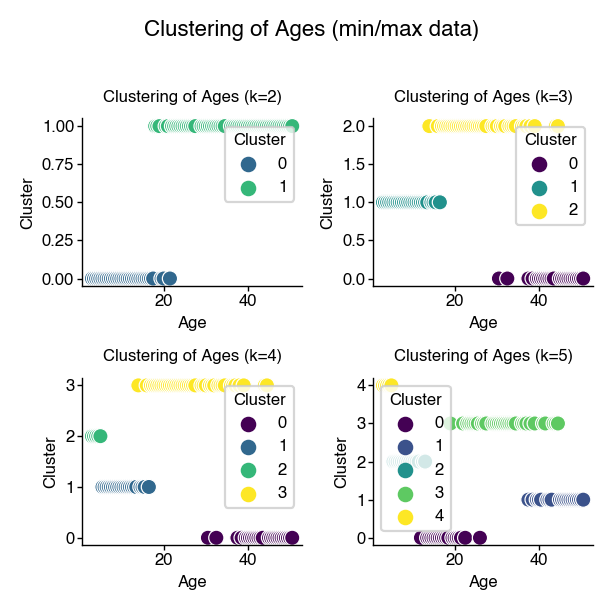

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


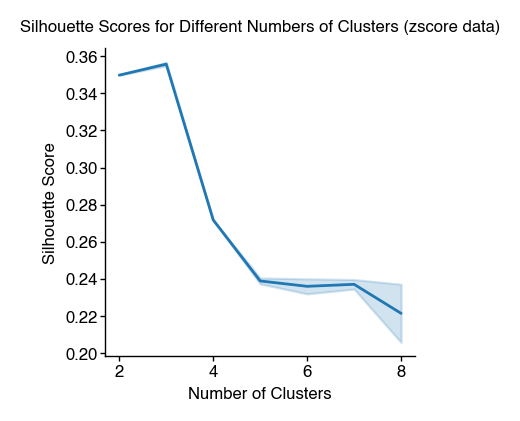

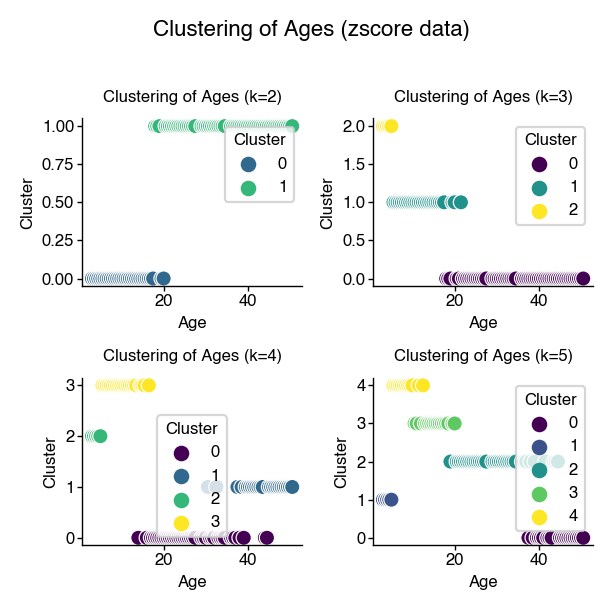

In [8]:
dataframes = [avg_m_df, avg_m_log, avg_m_norm, avg_z_m]
data_types = ['raw', 'log', 'min/max', 'zscore']

for df, data_type in zip(dataframes, data_types):
    X = df.values

    # Parameters for silhouette score calculation
    n_clusters_range = range(2, 9)
    n_init = 10  # Number of different seeds to try
    seeds = 10

    # Initialize lists to store the results
    mean_silhouette_scores = []
    std_silhouette_scores = []
    silhouette_scores = []
    cluster_num = []

    # Perform k-means clustering for each number of clusters and each random seed
    for n_clusters in n_clusters_range:
        for seed in range(seeds):
            kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=n_init)
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)
            cluster_num.append(n_clusters)

    # Create a DataFrame for silhouette scores
    sill = pd.DataFrame({
        'score': silhouette_scores,
        'n_clusters': cluster_num
    })

    # Plot the silhouette scores
    plt.figure(figsize=(2, 2))
    sns.lineplot(data=sill, x='n_clusters', y='score', estimator='mean', errorbar='sd')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Numbers of Clusters ({data_type} data)')
    sns.despine()
    plt.show()

    # Parameters for clustering visualization
    n_clusters_list = [2, 3, 4, 5]
    n_init = 10  # Number of different seeds to try

    # Set up the subplot grid for clustering visualization
    fig, axes = plt.subplots(2, 2, figsize=(3,3))
    axes = axes.flatten()

    # Perform k-means clustering for each specified number of clusters
    for i, n_clusters in enumerate(n_clusters_list):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=n_init)
        labels = kmeans.fit_predict(X)

        # Create DataFrame to visualize the clustering of ages
        clustered_ages = pd.DataFrame({
            'age': df.index.get_level_values('age'),
            'cluster': labels
        })

        # Plot the clustering of ages in the corresponding subplot
        sns.scatterplot(data=clustered_ages, x='age', y='cluster', hue='cluster', palette='viridis', s=30, ax=axes[i])
        axes[i].set_title(f'Clustering of Ages (k={n_clusters})')
        axes[i].set_xlabel('Age')
        axes[i].set_ylabel('Cluster')
        axes[i].legend(title='Cluster')
        sns.despine()

    # Adjust layout
    fig.suptitle(f'Clustering of Ages ({data_type} data)', fontsize=8)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## H clustering

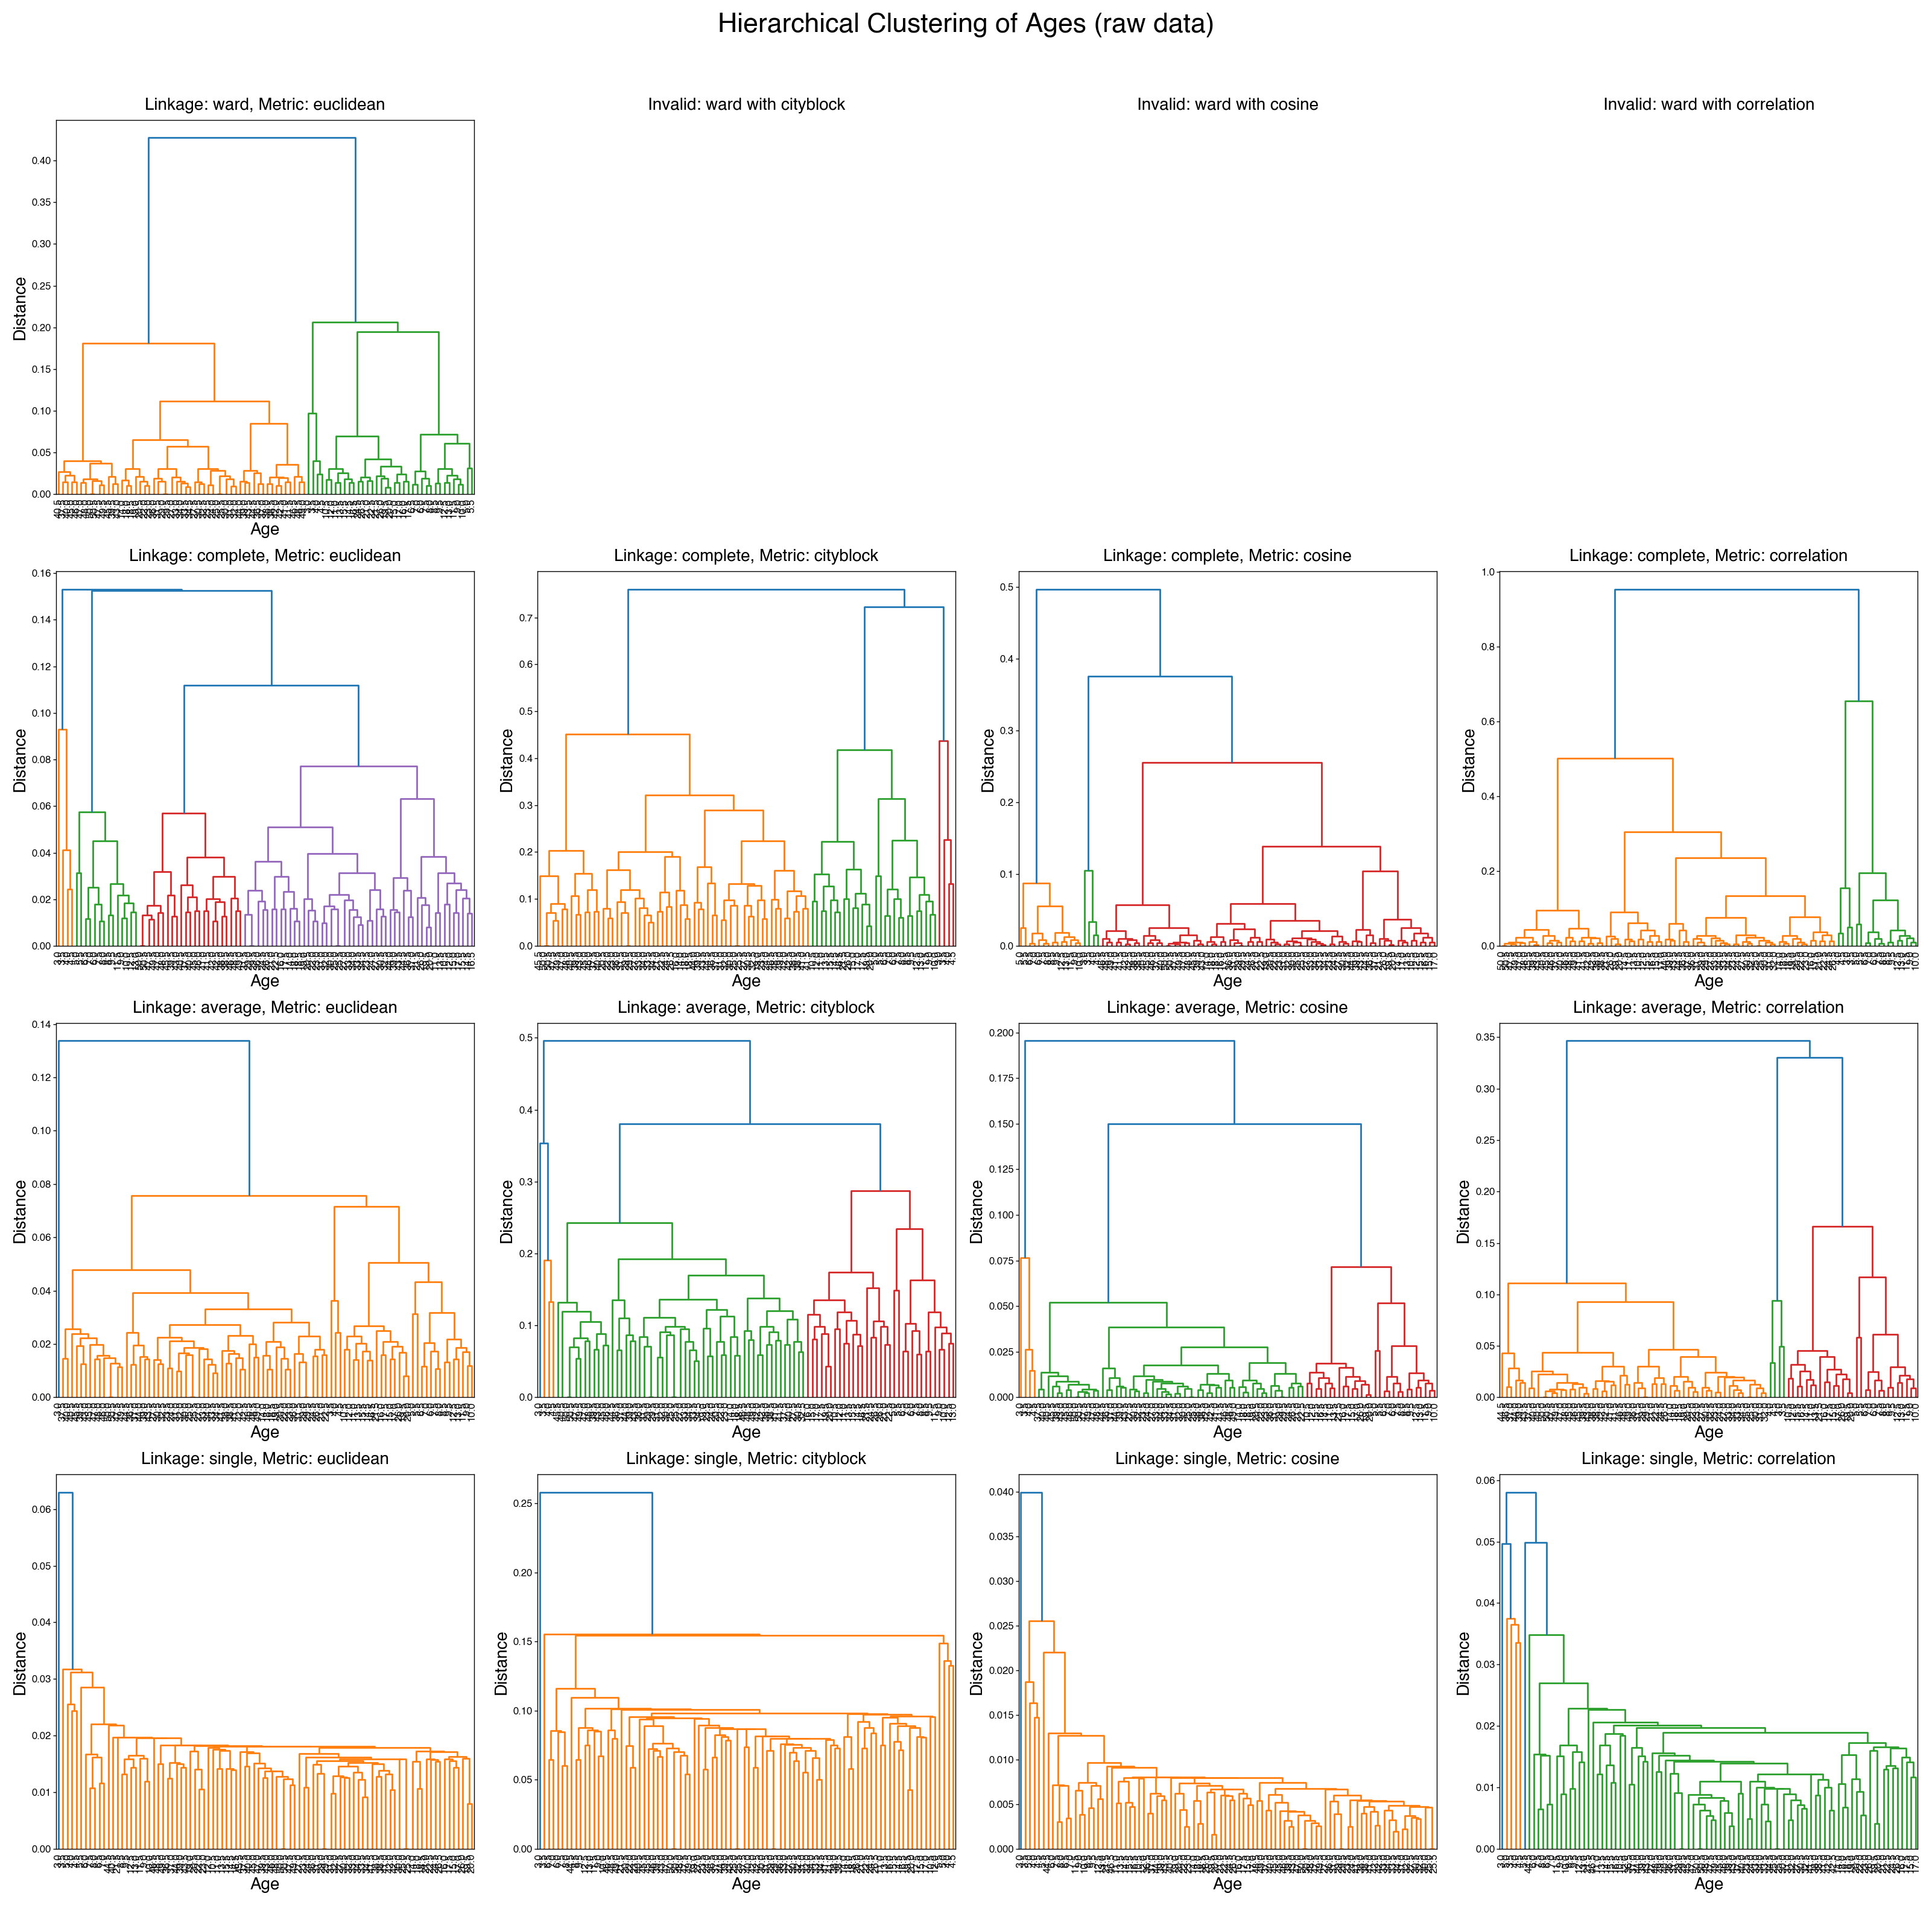

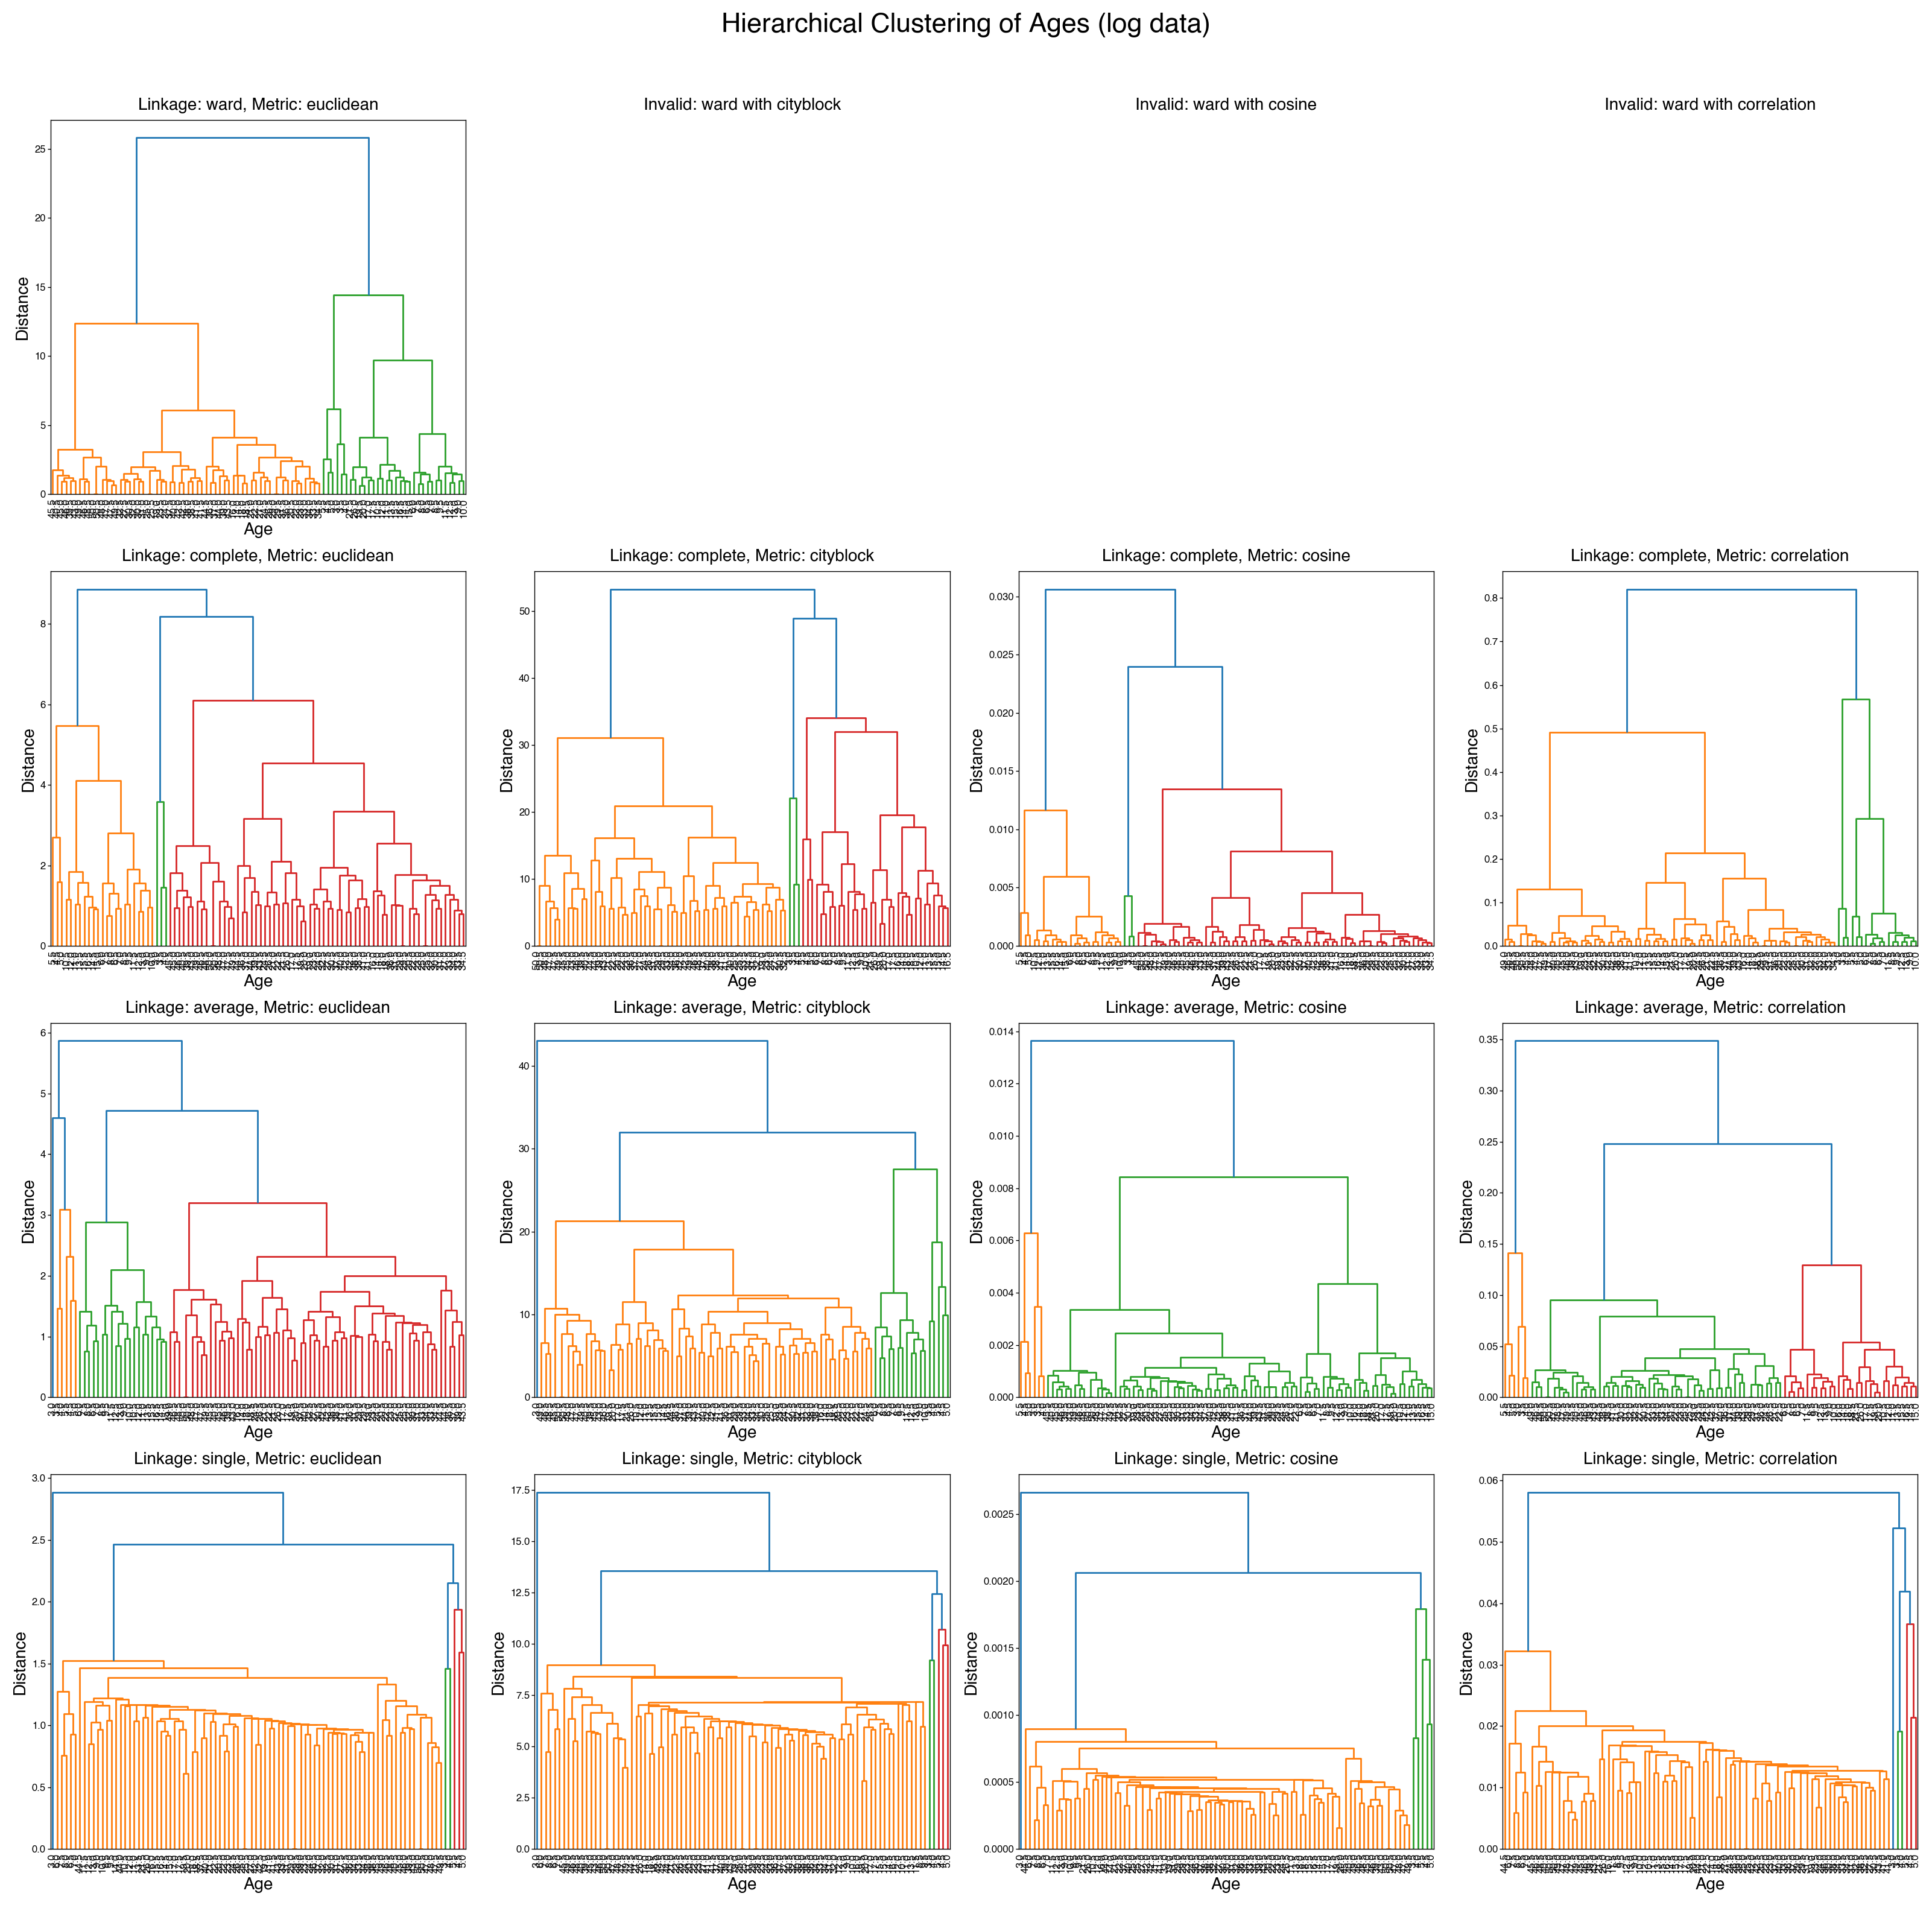

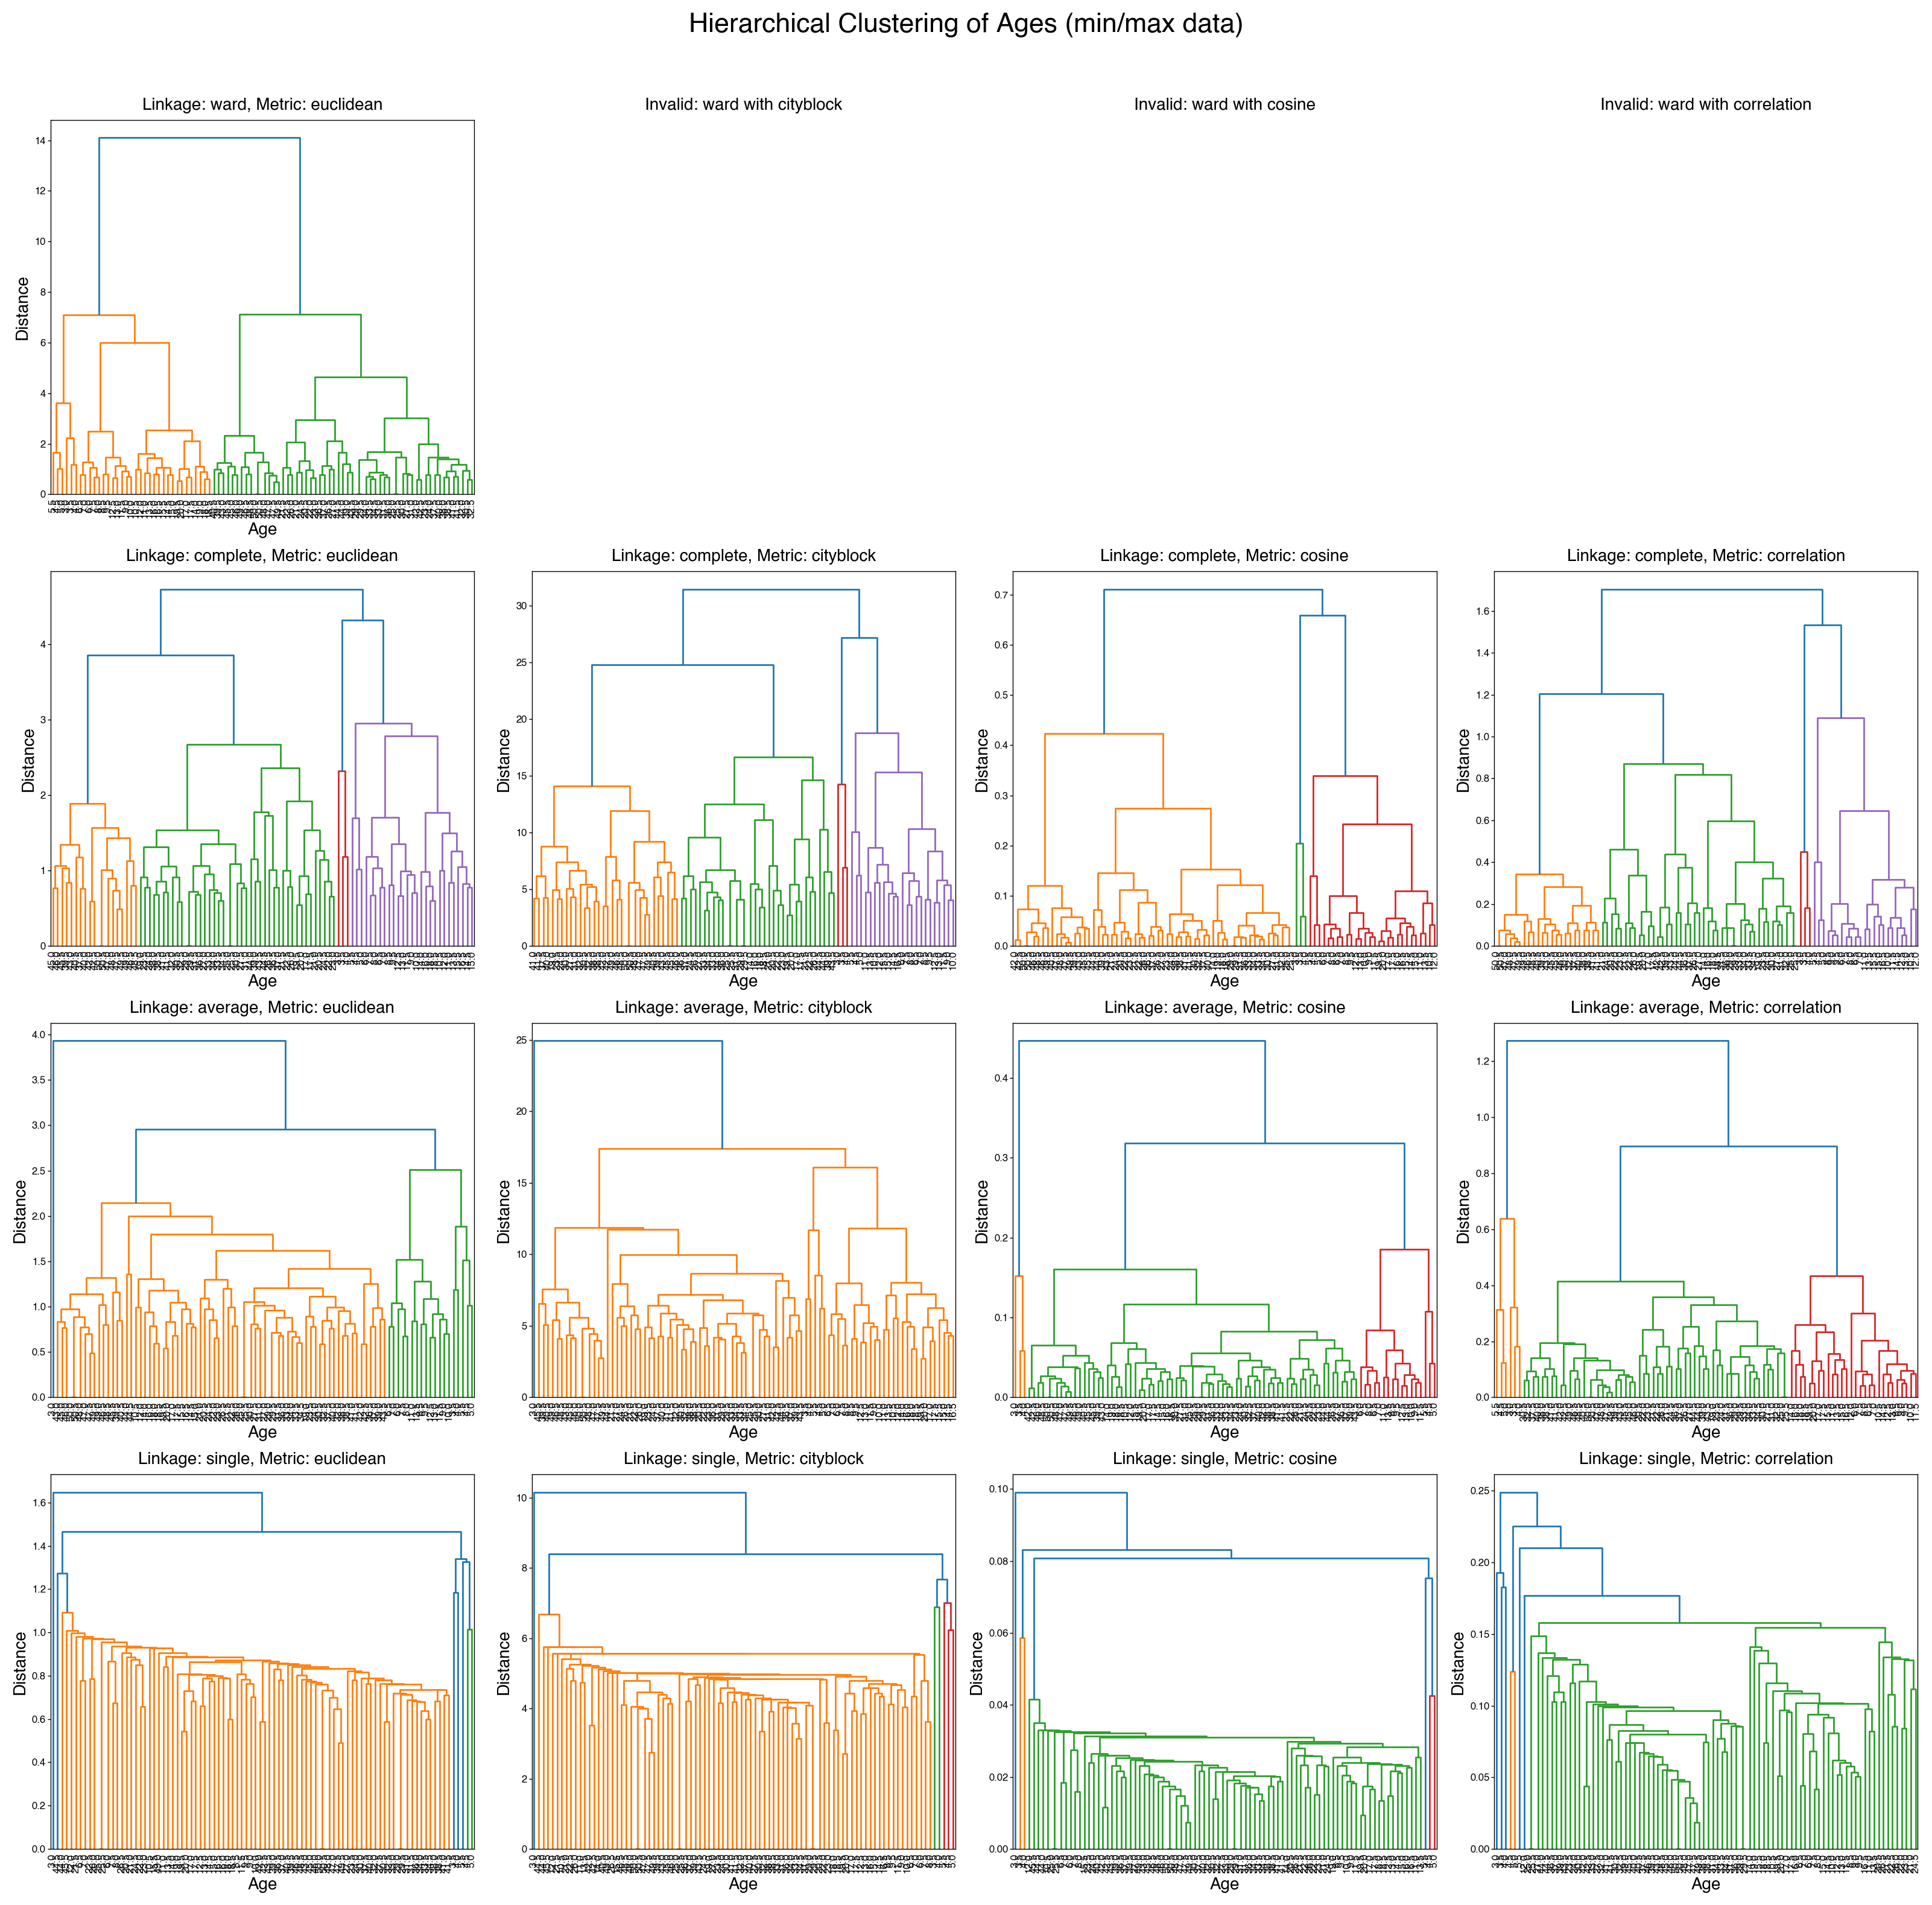

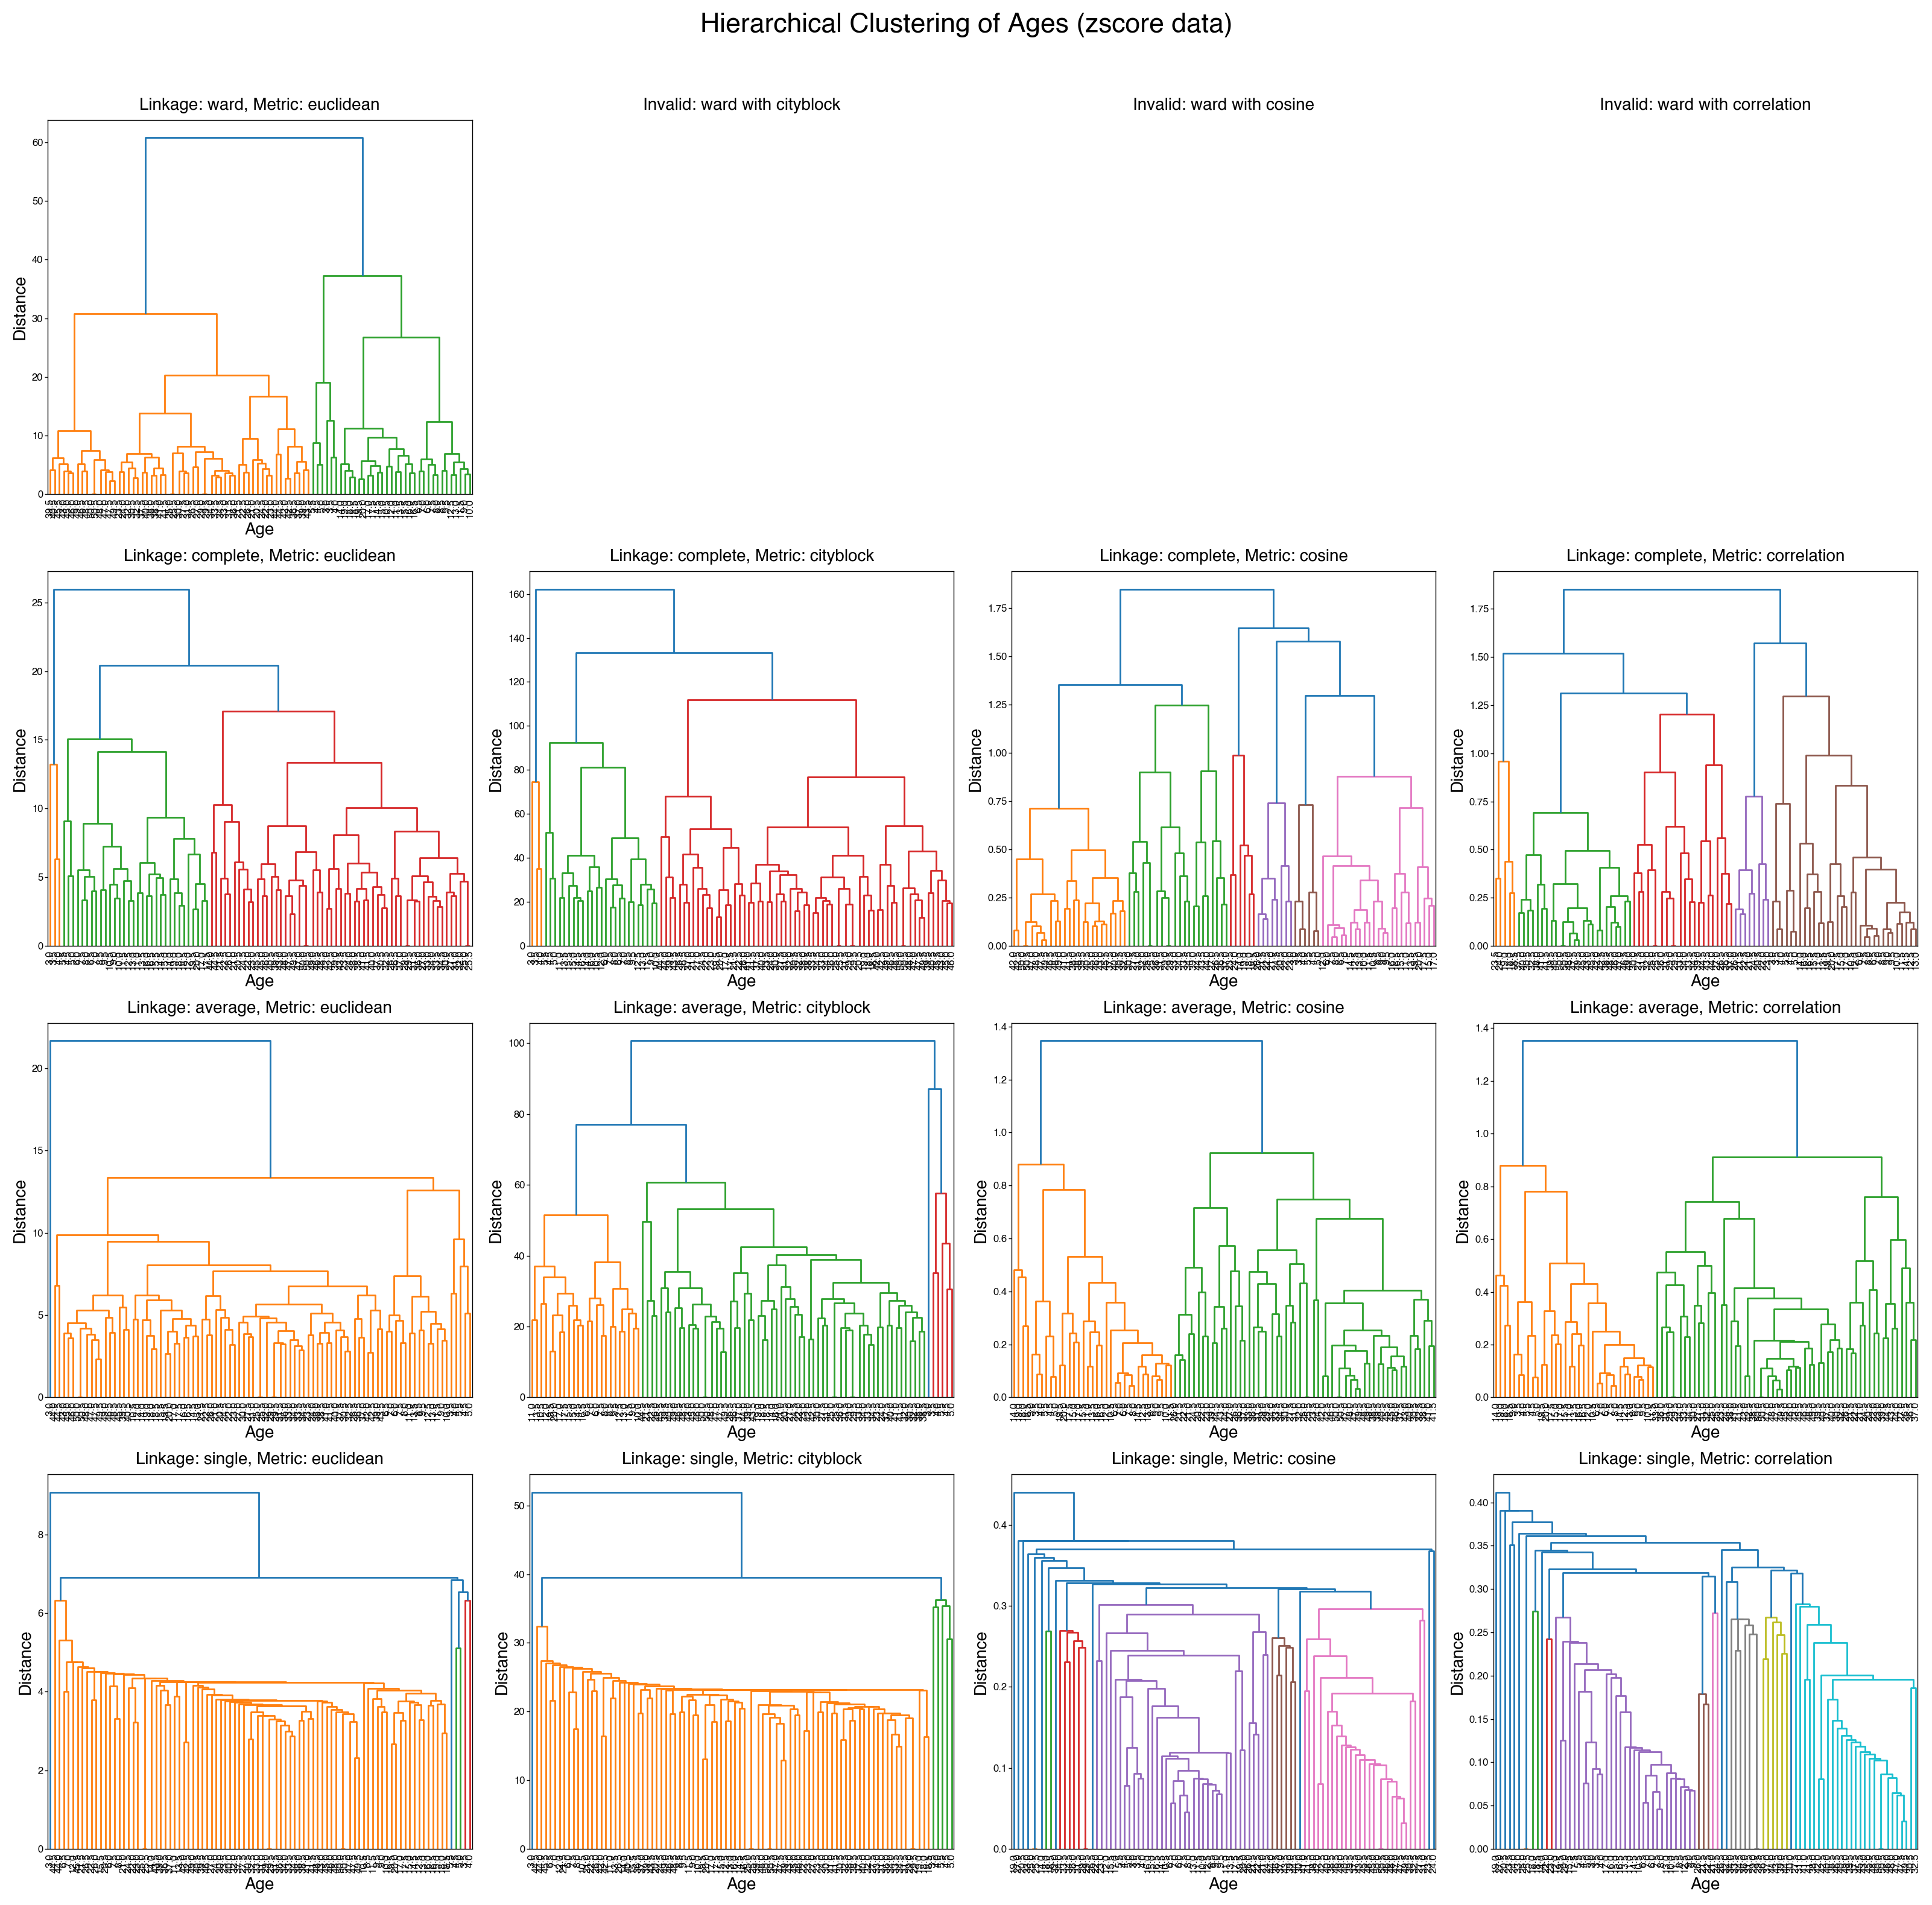

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
dataframes = [avg_m_df, avg_m_log, avg_m_norm, avg_z_m]
data_types = ['raw', 'log', 'min/max', 'zscore']


# Parameters for hierarchical clustering
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

for df, data_type in zip(dataframes, data_types):
    X = df.values

    # Set up the subplot grid
    fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(16, 16))
    fig.suptitle(f'Hierarchical Clustering of Ages ({data_type} data)', fontsize=16)

    for i, method in enumerate(linkage_methods):
        for j, metric in enumerate(distance_metrics):
            if method == 'ward' and metric != 'euclidean':
                axes[i, j].axis('off')  # Turn off the axis if the combination is invalid
                axes[i, j].set_title(f'Invalid: {method} with {metric}', fontsize=10)
            else:
                ax = axes[i, j]
                if metric in ['cityblock', 'cosine', 'correlation']:
                    dists = pdist(X, metric=metric)
                    Z = linkage(dists, method=method)
                else:
                    Z = linkage(X, method=method, metric=metric)
                dendro = dendrogram(Z, labels=df.index.get_level_values('age'), ax=ax, leaf_rotation=90)
                ax.set_title(f'Linkage: {method}, Metric: {metric}', fontsize=10)
                ax.set_xlabel('Age', fontsize=10)
                ax.set_ylabel('Distance', fontsize=10)
                ax.tick_params(axis='x', labelsize=6)
                ax.tick_params(axis='y', labelsize=6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## umap

In [ ]:
format_plots()

In [ ]:
import umap
df=avg_m_norm.copy()

reducer = umap.UMAP(random_state=10,n_neighbors=5, min_dist=0.05)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap='cubehelix',
    s=8,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

In [ ]:
# Assuming avg_m_norm is already defined and is a DataFrame
df = avg_m_norm.copy()

# Define ranges for UMAP parameters
n_neighbors_range = [5,10]
min_dist_range = [0.05, 0.1]
spread_range = [0.5, 1.0]

# Create subplots
fig, axs = plt.subplots(len(n_neighbors_range), len(min_dist_range) * len(spread_range), figsize=(4, 4))
fig.tight_layout(pad=3.0)

# Loop over all combinations of the parameters
for i, n_neighbors in enumerate(n_neighbors_range):
    for j, min_dist in enumerate(min_dist_range):
        for k, spread in enumerate(spread_range):
            ax = axs[i, j * len(spread_range) + k]

            # Initialize UMAP with current parameters
            reducer = umap.UMAP(random_state=10, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread)
            umap_result = reducer.fit_transform(df)

            pcs = pd.DataFrame(umap_result, columns=['dim1', 'dim2'])
            pcs['age'] = df.index.get_level_values('age')

            # Scatter plot
            im = ax.scatter(
                x=pcs['dim1'], y=pcs['dim2'],
                c=pcs['age'],
                cmap='cubehelix',
                s=15,
                linewidth=0.25
            )

            # Customize the plot
            ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}')
            ax.set_xlabel('dim1')
            ax.set_ylabel('dim2')
            #ax.set_aspect('equal')  # Ensure each panel is square
            sns.despine(ax=ax)

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()